In [87]:
filename='test/a0001.wav'

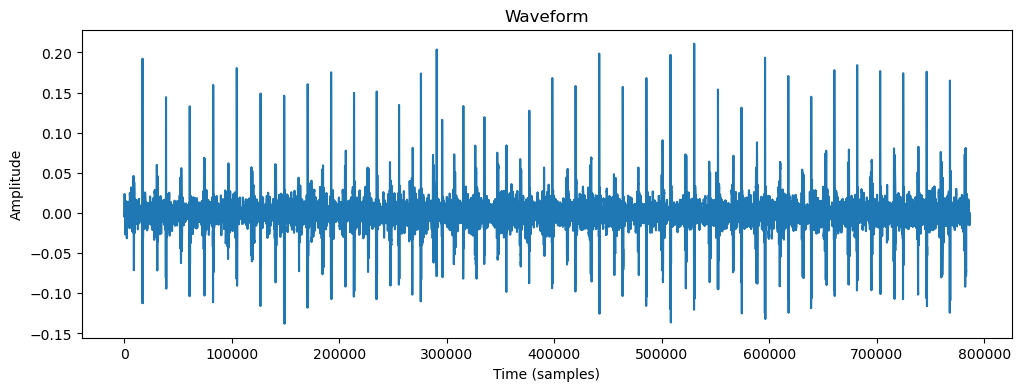

In [88]:
import librosa
import matplotlib.pyplot as plt


data, sample_rate = librosa.load(filename)

plt.figure(figsize=(12, 4))
plt.plot(data)

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Waveform')


plt.show()


In [3]:
import pandas as pd

metadata=pd.read_excel('dataset/Frankentstein-data.xlsx')
metadata['recordings'] = metadata['recordings'].astype(str) + '.wav'
metadata.head(10)

,recordings,results
0,a0001.wav,1
1,a0002.wav,1
2,a0003.wav,1
3,a0004.wav,1
4,a0005.wav,1
5,a0006.wav,1
6,a0007.wav,-1
7,a0008.wav,1
8,a0009.wav,-1
9,a0010.wav,1


In [4]:
metadata['results'].value_counts()

results
-1    2575
 1     665
Name: count, dtype: int64

In [5]:
import pandas as pd
import os
import librosa
import numpy as np
from tqdm import tqdm

audio_dataset_path = 'recordings/'


def features_extractor(file):
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features

# Now we iterate through every audio file and extract features using Mel-Frequency Cepstral Coefficients
new_dataset = []

# Iterate through each row of the original dataset
for index, row in metadata.iterrows():
    file_path = os.path.join(audio_dataset_path, row['recordings'])  # Get the file path from the 'recordings' column
    label = row['results']  # Get the label from the 'results' column
    try:
        # Extract MFCCs from audio file
        mfccs = features_extractor(file_path)
        # Append MFCCs and label to the new dataset
        new_dataset.append({'mfccs': mfccs, 'label': label})
    except Exception as e:
        print(f"Error processing file '{file_path}': {e}")

# Convert the new dataset to a DataFrame
new_dataset_df = pd.DataFrame(new_dataset)


In [7]:
new_dataset_df

,mfccs,label
0,"[-576.862, 117.566956, 82.46526, 40.06241, 6.2...",1
1,"[-627.9096, 137.26224, 100.363914, 55.458004, ...",1
2,"[-600.3022, 78.11143, 61.655224, 41.402103, 24...",1
3,"[-561.78186, 89.5558, 71.56037, 48.790478, 28....",1
4,"[-488.9869, 66.225845, 57.067467, 44.92165, 33...",1
...,...,...
3235,"[-437.53558, 150.68073, 111.69659, 63.005108, ...",-1
3236,"[-451.50192, 143.38852, 107.08906, 61.230377, ...",-1
3237,"[-484.0257, 138.31699, 103.63479, 59.68415, 20...",-1
3238,"[-457.9254, 134.91615, 101.431366, 59.40049, 2...",-1


In [8]:
new_dataset_df['label']

0       1
1       1
2       1
3       1
4       1
       ..
3235   -1
3236   -1
3237   -1
3238   -1
3239   -1
Name: label, Length: 3240, dtype: int64

In [9]:
X=np.array(new_dataset_df['mfccs'].tolist())
y = new_dataset_df['label']

In [10]:
X.shape

(3240, 40)

In [11]:
y.shape

(3240,)

In [56]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)
sc = StandardScaler()
sm = SMOTE(random_state=27)
X_train, y_train = sm.fit_resample(X_train, y_train)
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)


In [57]:
X_train

array([[ 0.96700174,  1.150787  ,  1.0290353 , ...,  0.8082952 ,
         1.3212382 ,  0.91330874],
       [ 0.20188266,  1.4472797 ,  1.1928436 , ..., -0.0715801 ,
        -0.09491973, -0.9723974 ],
       [ 0.10467888,  1.7896128 ,  1.9795262 , ..., -0.3864951 ,
        -0.7181302 , -1.349084  ],
       ...,
       [-0.74308205, -0.74432355, -1.0724782 , ..., -0.02184489,
         0.59504557,  0.8948167 ],
       [-0.94496477, -0.3641724 , -0.4291971 , ..., -0.08477781,
        -0.01382689,  0.43705893],
       [ 0.01276192, -0.7389164 , -0.62499404, ..., -0.4823432 ,
        -0.424905  ,  0.02263153]], dtype=float32)

In [58]:
X_train.shape

(4098, 40)

In [59]:
X_test.shape

(648, 40)

In [60]:
y_train.shape

(4098,)

In [61]:
y_test.shape

(648,)

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [63]:
num_labels=y.shape[0]
num_labels

3240

In [64]:
from keras.utils import to_categorical
y_train= to_categorical(y_train, num_classes=num_labels)
y_test= to_categorical(y_test, num_classes=num_labels)

In [37]:
model=Sequential()
###first layer
model.add(Dense(512,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
###second layer
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.2))

###final layer
model.add(Dense(num_labels))
model.add(Activation('sigmoid'))

In [38]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 512)                 │          20,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 3240)                │         210,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 3240)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 404,072 (1.54 MB)

 Trainable params: 404,072 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
## Trianing my model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from datetime import datetime 

lrd = ReduceLROnPlateau(monitor = 'val_loss',
                         patience = 200,
                         verbose = 1,
                         factor = 0.75,
                         min_lr = 1e-10)

mcp = ModelCheckpoint('model.keras')

es = EarlyStopping(verbose=1, patience=600)

In [41]:
history = model.fit(x=X_train, y=y_train, epochs=1000, callbacks=[lrd, mcp, es], batch_size=64, validation_split=0.2)

Epoch 1/1000
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2533 - loss: 0.3518 - val_accuracy: 0.0000e+00 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 2/1000
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5821 - loss: 7.7059e-04 - val_accuracy: 0.0000e+00 - val_loss: 6.5231e-04 - learning_rate: 0.0010
Epoch 3/1000
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5720 - loss: 5.5499e-04 - val_accuracy: 0.0000e+00 - val_loss: 5.4169e-04 - learning_rate: 0.0010
Epoch 4/1000
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6125 - loss: 4.1715e-04 - val_accuracy: 0.0000e+00 - val_loss: 7.6436e-04 - learning_rate: 0.0010
Epoch 5/1000
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6158 - loss: 3.9742e-04 - val_accuracy: 0.0000e+00 - val_loss: 8.0912e-04 - learning_rate: 0.0010
Epoch 6/1000
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6511 - loss: 3.7420e-04 - val_accuracy: 0.0000e+00 - val_loss: 7.4987e-04 - learning_rate: 0.0010
Epoch 7/1000
52/52 

In [52]:
from keras.models import load_model

In [65]:
model = load_model('model.keras')

In [66]:
model.evaluate(X_test , y_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9133 - loss: 6.4595e-04


[0.0004896180471405387, 0.9212962985038757]

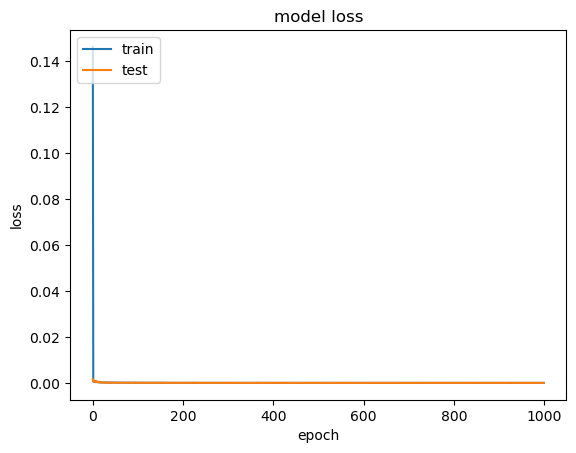

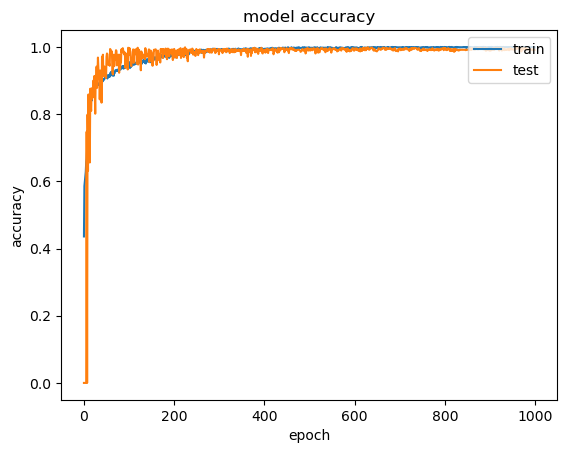

In [67]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# # summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [69]:
import joblib
scaler = joblib.load("scaler.h5")

In [82]:
prediction_features = features_extractor("a0001.wav")
prediction_features = prediction_features.reshape(1, -1)
prediction_features = scaler.transform(prediction_features)

# Make predictions
predicted_probabilities = model.predict(prediction_features)
predicted_probabilities=np.array(predicted_probabilities.tolist())
predicted_class = np.argmax(predicted_probabilities, axis=1)
predicted_value = predicted_class[0]
predicted_value

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


1